# 2. Entrenamiento de RNNs en una Serie de Tiempo

**2.0 Imports necesarios**

In [183]:
import pandas
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
import matplotlib.pyplot as plt
import time

**2.1 Creación de conjuntos de entrenamiento y prueba**

En primer lugar, se crean los conjuntos de entrenamiento y de prueba por medio de la función *create_sets*. Esta función también se encarga de escalar los datos de cada conjunto. El dataset original está compuesto por un total de 144 registros, de los cuales 96 estarán destinados a conformar el conjunto de entrenamiento, mientras que los 48 restantes formarán parte del conjunto de pruebas.

In [101]:
# Función para la creación de conjuntos de entrenamiento y prueba
def create_sets(file_name):
    # Se lee archivo que contiene todos los datos
    dataframe = pandas.read_csv(file_name, sep=',', usecols=[1], engine='python', skipfooter=3)
    # Se utiliza precisión de 32 bits para atributos numéricos
    dataframe[:] = dataframe[:].astype('float32')
    # Se crean conjuntos de entrenamiento y de prueba
    df_train, df_test = dataframe[0:96].values, dataframe[96:].values
    # Se escalan los datos de cada conjunto
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
    stream_train_scaled = scaler.transform(df_train)
    stream_test_scaled = scaler.transform(df_test)
    return scaler, list(stream_train_scaled), list(stream_test_scaled)

# Se crean conjuntos a partir de archivo .csv
scaler, train_set, test_set = create_sets('international-airline-passengers.csv')

**2.2 Generación de atributos predictores y atributo a predecir**

Ya creados los conjuntos de entrenamiento y de prueba, se procede a construir, para cada caso, la matriz X y el vector Y. La matriz X contendrá, para cada registro, la cantidad de pasajeros en los tiempos x(t-2), x(t-1) y x(t), o en otras palabras, los atributos predictores. Por otro lado, el vector Y almacenará en la casilla correspondiente la cantidad de pasajeros en el tiempo x(t+1), es decir, el atributo a predecir. El procedimiento descrito será llevado a cabo por medio de la función *create_dataset*.

In [102]:
# Función encargada de separar valores predictores y valores a predecir
def create_dataset(sequence, lag):
    dataX = []
    dataY = []
    for i in range(lag, len(sequence)):
        # Se crea matriz X
        dataX.append(sequence[i - lag : i])
        # Se crea vector Y
        dataY.append(sequence[i])
    return np.array(dataX), np.array(dataY)

Así, se crea la matriz X y el vector Y en base a los conjuntos de entrenamiento y de prueba. Se utilizará lag = 3, en primera instancia.

In [103]:
# Inicialmente, se usará lag = 3
lag = 3
# Se crea matriz X y vector Y en base a conjuntos de entrenamiento y prueba
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)

In [104]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

De esta forma, la matriz X poseen dimensiones (número de ejemplos, time step, número de atributos predictores) tanto para el caso de entrenamiento como para el caso de pruebas.

**2.3 Entrenamiento de red LSTM**

A partir de las matrices creadas en la sección anterior, se entrena y posteriormente se evalúa una red LSTM. Recordar que se está utilizando un lag de 3.

In [108]:
ti = time.time()
model = Sequential()
model.add(LSTM(4, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1)
tf = time.time()

Epoch 1/100
93/93 [==============================] - 1s - loss: 0.1215     
Epoch 2/100
93/93 [==============================] - 1s - loss: 0.0582     
Epoch 3/100
93/93 [==============================] - 1s - loss: 0.0296     
Epoch 4/100
93/93 [==============================] - 1s - loss: 0.0221     
Epoch 5/100
93/93 [==============================] - 1s - loss: 0.0193     
Epoch 6/100
93/93 [==============================] - 1s - loss: 0.0175     
Epoch 7/100
93/93 [==============================] - 1s - loss: 0.0157     
Epoch 8/100
93/93 [==============================] - 1s - loss: 0.0145     
Epoch 9/100
93/93 [==============================] - 1s - loss: 0.0130     
Epoch 10/100
93/93 [==============================] - 1s - loss: 0.0122     
Epoch 11/100
93/93 [==============================] - 1s - loss: 0.0114     
Epoch 12/100
93/93 [==============================] - 1s - loss: 0.0109     
Epoch 13/100
93/93 [==============================] - 1s - loss: 0.0105     
Epoch 14

**2.4 Determinación de error y de prueba**

...

In [110]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

...

In [111]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Error de entrenamiento: 23.2439285062 RMSE
Error de prueba: 62.33960865 RMSE


...

**2.5 Comparación de predicciones**

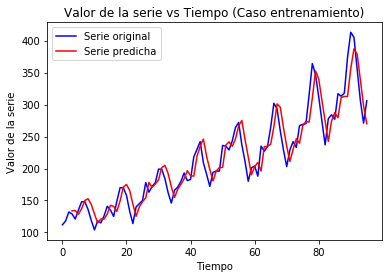

In [113]:
plt.plot(range(len(train_set)), scaler.inverse_transform(train_set), 'b')
plt.plot(range(len(train_set))[lag:], list(trainPredict), 'r')
plt.title('Valor de la serie vs Tiempo (Caso entrenamiento)')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la serie')
plt.legend(['Serie original', 'Serie predicha'], loc='best')
plt.show()

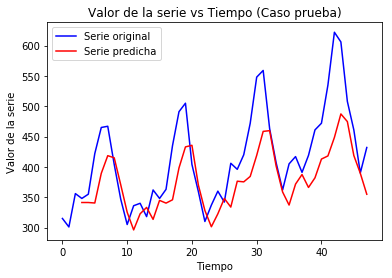

In [114]:
plt.plot(range(len(test_set)), scaler.inverse_transform(test_set), 'b')
plt.plot(range(len(test_set))[lag:], list(testPredict), 'r')
plt.title('Valor de la serie vs Tiempo (Caso prueba)')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la serie')
plt.legend(['Serie original', 'Serie predicha'], loc='best')
plt.show()

...

**2.6 Determinación de bloques LSTM**

In [124]:
kfold = cross_validation.KFold(trainX.shape[0], 5)

for nb in range(4, 13, 2):
    cv_errors = []
    times = []
    print 'Numero de bloques:', nb
    for i, (train, val) in enumerate(kfold):
        model = None
        ti = time.time()
        model = Sequential()
        model.add(LSTM(nb, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX[train], trainY[train], epochs=100, batch_size=1, verbose=0)
        tf = time.time()
        times = times.append(tf - ti)
        trainPredict_val = model.predict(trainX[val])
        trainPredict_val = scaler.inverse_transform(trainPredict_val)
        trainY_val = scaler.inverse_transform(trainY[val])
        error = math.sqrt(mean_squared_error(trainY_val, trainPredict_val))
        cv_errors.append(error)
    mean_time = np.mean(times)
    mse_cv = np.mean(cv_errors)
    tf = time.time()
    print 'Tiempo de entrenamiento promedio:', tf - ti, '[s]'
    print 'Error promedio:', mse_cv
    print ''

Numero de bloques: 4
Error promedio: 23.2740790891

Numero de bloques: 6
Error promedio: 22.8397448955

Numero de bloques: 8
Error promedio: 22.3714516098

Numero de bloques: 10
Error promedio: 22.137142174

Numero de bloques: 12
Error promedio: 22.8250266266



**2.7 Variación de lag**

In [125]:
for lag in range(1, 5):
    trainX, trainY = create_dataset(train_set, lag)
    testX, testY = create_dataset(test_set, lag)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    t_i = time.time()
    model = Sequential()
    model.add(LSTM(10, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
    t_f = time.time()
    
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    
    print 'Lag:', lag
    print 'Tiempo de entrenamiento:', tf - ti, '[s]'
    print 'Error de entrenamiento:', trainScore, 'RMSE'
    print 'Error de prueba:', testScore, 'RMSE\n'

Lag: 1
Error de entrenamiento: 22.9359632596 RMSE
Error de prueba: 48.4404258189 RMSE

Lag: 2
Error de entrenamiento: 21.5930193323 RMSE
Error de prueba: 57.8949749547 RMSE

Lag: 3
Error de entrenamiento: 21.5263956962 RMSE
Error de prueba: 54.425293282 RMSE

Lag: 4
Error de entrenamiento: 22.3738986123 RMSE
Error de prueba: 62.9013965931 RMSE



**2.8 Comparación con RNN simple y GRU**

In [130]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [129]:
ti = time.time()
model = Sequential()
model.add(GRU(10, input_shape=(None, lag), recurrent_initializer='orthogonal', activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)
tf = time.time()

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Error de entrenamiento: 21.5233680239 RMSE
Error de prueba: 62.0128849546 RMSE


In [131]:
ti = time.time()
model = Sequential()
model.add(SimpleRNN(10, input_shape=(None, lag), recurrent_initializer='orthogonal', activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)
tf = time.time()

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Error de entrenamiento: 23.1348730507 RMSE
Error de prueba: 74.1401985631 RMSE


**2.9 Entrenamiento de red LSTM con timestep = 3**

In [134]:
lag = 1
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

ti = time.time()
model = Sequential()
model.add(LSTM(10, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1)
tf = time.time()

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

Epoch 1/100
95/95 [==============================] - 0s - loss: 0.1535     
Epoch 2/100
95/95 [==============================] - 0s - loss: 0.0810     
Epoch 3/100
95/95 [==============================] - 0s - loss: 0.0488     
Epoch 4/100
95/95 [==============================] - 0s - loss: 0.0381     
Epoch 5/100
95/95 [==============================] - 0s - loss: 0.0339     
Epoch 6/100
95/95 [==============================] - 0s - loss: 0.0298     
Epoch 7/100
95/95 [==============================] - 0s - loss: 0.0263     
Epoch 8/100
95/95 [==============================] - 0s - loss: 0.0227     
Epoch 9/100
95/95 [==============================] - 0s - loss: 0.0195     
Epoch 10/100
95/95 [==============================] - 0s - loss: 0.0163     
Epoch 11/100
95/95 [==============================] - 0s - loss: 0.0137     
Epoch 12/100
95/95 [==============================] - 0s - loss: 0.0113     
Epoch 13/100
95/95 [==============================] - 0s - loss: 0.0096     
Epoch 14

In [135]:
print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Error de entrenamiento: 23.2411738224 RMSE
Error de prueba: 48.445939285 RMSE


**2.10 Entrenamiento de red LSTM con memoria entre batches**

**2.10.1 Batch size = 1**

In [162]:
lag = 1
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 1
ti = time.time()
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()
tf = time.time()

Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0284     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0307     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0175     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0129     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0127     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0127     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0123     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0120     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0117     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0115     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0113     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0111     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0110     
Epoch 1/1
95/95 [=====================

In [163]:
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Error de entrenamiento: 20.5385290797 RMSE
Error de prueba: 53.5237128925 RMSE


**2.10.2 Batch size = 3**

In [176]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 3
ti = time.time()
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()
tf = time.time()

Epoch 1/1
93/93 [==============================] - 0s - loss: 0.1414     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0512     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0307     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0320     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0283     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0245     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0212     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0183     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0158     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0139     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0126     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0118     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0114     
Epoch 1/1
93/93 [=====================

In [177]:
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Error de entrenamiento: 20.5560340803 RMSE
Error de prueba: 41.6435505539 RMSE


**2.11 Entrenamiento de LSTM apilada**

In [181]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 3

ti = time.time()
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True))
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True))
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()
tf = time.time()

Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0767     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0311     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0211     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0156     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0131     
Epoch 1/1
93/93 [==============================] - 2s - loss: 0.0117     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0124     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0125     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0115     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0119     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0121     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0115     
Epoch 1/1
93/93 [==============================] - 1s - loss: 0.0116     
Epoch 1/1
93/93 [=====================

In [182]:
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Error de entrenamiento: 21.7856160718 RMSE
Error de prueba: 49.4683058255 RMSE
